# Numerical analyses of $Maxwellian-sech^2$-type electron hole

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib
import scipy.optimize as op
import plasmapy
from scipy import special as sp
from scipy import integrate
from tqdm import tqdm
import numba as nb
import math
from prettytable import PrettyTable
%config InlineBackend.figure_format = 'svg'

In [2]:
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({'lines.linewidth': 2})

In [3]:
T = 1
# k = 0.1
# L = 2*np.pi/k
L = 100


vmax = 10 # 速度最大值
nx = 500
nv = 500
dx = L/(nx-1)
dv = 2*vmax/(nv-1)
x = np.linspace(0, L, num=nx, endpoint=True)
v = np.linspace(-vmax, vmax, num=nv, endpoint=True)

## sech2分布
$$ f_u(w>0) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}(\pm \sqrt{2w}+u)^2 } $$
$$ f_t(w<0) = \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}u^2} [1 - (1-u^2)w] $$
其中$w=v^2/2-\phi$
## 理论自洽解
$$ \phi = \psi sech^2 \left(\frac{\sqrt{B_s}x}{2}\right) $$
$$ B_s = 1 + \frac{u}{\sqrt{2}} Z\left(\frac{u}{\sqrt{2}}\right) $$
$$ D_s = \frac{(3-u^2)B_s-1}{2} $$

In [4]:
import mpmath as mp
mp.dps=10
def B_M_nonvec(u):
    r = 1.0+u/np.sqrt(2)*plasmapy.dispersion.plasma_dispersion_func(u/np.sqrt(2)).real
    return r

def D_M_nonvec(u):
    r = ( (3.0-u**2)*B_M_nonvec(u)-1.0 )/4.0
    return r

def E_M_nonvec(u):
    r = -8.0/45.0/np.sqrt(np.pi)*np.exp(-u**2/2)*(u**4-6*u**2+3)
    return r

def F_M_nonvec(u):
    theta = np.sqrt(2)
    xi = u/theta
    Z = plasmapy.dispersion.plasma_dispersion_func(xi).real
    Z1 = -2*(1+xi*Z)
    Z2 = -2*(Z+xi*Z1)
    Z3 = -2*(2*Z1+xi*Z2)
    Z4 = -2*(3*Z2+xi*Z3)
    Z5 = -2*(4*Z3+xi*Z4)
    r = -Z5/384.0
    return r

B_M = np.vectorize(B_M_nonvec)
D_M = np.vectorize(D_M_nonvec)
E_M = np.vectorize(E_M_nonvec)
F_M = np.vectorize(F_M_nonvec)

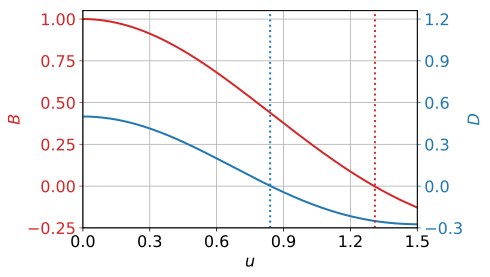

In [51]:
u = np.linspace(0.,1.5,num=200)
ax1_yticks = [-0.25,0,0.25,0.5,0.75,1.0]
ax2_yticks = [-0.3,0,0.3,0.6,0.9,1.2]
xticks = [0.0,0.3,0.6,0.9,1.2,1.5]

ul = 0.84
ur = 1.31

fig = plt.figure(figsize=(6,4))
ax1 = fig.gca()

ax1.plot(u,B_M(u),label='B',color='tab:red')
ax1.set_xlabel(r'$u$')
ax1.set_ylabel(r'$B$',color='tab:red')
ax1.set_xticks(xticks)
ax1.set_yticks(ax1_yticks)
ax1.tick_params(axis='y', colors='tab:red')
ax1.set_xlim(0.,1.5)
ax1.set_ylim(-0.25,1.05)
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(u,D_M(u),label='D',color='tab:blue')
ax2.set_ylabel(r'$D$',color='tab:blue')
ax2.set_xticks(xticks)
ax2.set_yticks(ax2_yticks)
ax2.tick_params(axis='y', colors='tab:blue')
ax2.set_xlim(0.,1.5)
ax2.set_ylim(-0.3,1.26)

plt.axvline(ul,linestyle=':',color='tab:blue')
plt.axvline(ur,linestyle=':',color='tab:red')

plt.show()

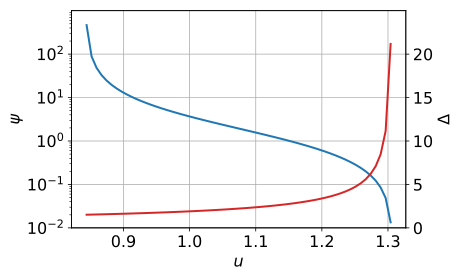

In [61]:
psi = -3.0*B_M(u)/D_M(u)/2.0
psi[psi<0] = np.nan

delta = np.sqrt(1.0/B_M(u[psi>=0]))

ax1_yticks = [1e-2,1e-1,1e0,1e1,1e2]
ax2_yticks = [0,5,10,15,20]

fig = plt.figure(figsize=(6,4))
ax1 = fig.gca()
ax1.plot(u[psi>0],psi[psi>0],color='tab:blue')
ax1.set_yscale('log')
ax1.set_xlabel(r'$u$')
ax1.set_ylabel(r'$\psi$')
ax1.set_yticks(ax1_yticks)
ax1.set_ylim(1e-2,1e3)
ax1.grid()

ax2 = ax1.twinx()
ax2.plot(u[psi>=0],delta,color='tab:red')
ax2.set_ylabel(r'$\Delta$')
ax2.set_yticks(ax2_yticks)
ax2.set_ylim(0,25)
# ax2.set_yscale('log')
plt.show()

In [64]:
def nonvec_f_sech2(v,phi):
    r = 0
    v_waveframe = v
    w = (v_waveframe**2)/2-phi
    if w>0:
        if v_waveframe<=-(2*phi)**0.5:
            r=math.exp(-(-(2*w)**0.5+u)**2/2) 
        elif v_waveframe>(2*phi)**0.5:
            r=math.exp(-( (2*w)**0.5+u)**2/2) 
    else:
        r = math.exp(-u**2/2)*(1+(-w)*(1-u**2))
    return r/(2*np.pi)**0.5
f_sech2 = np.vectorize(nonvec_f_sech2)

In [76]:
u = 1.2
psi = -3.0*B_M(u)/D_M(u)/2.0
delta = np.sqrt(1.0/B_M(u))
xp = (x-L/2)/delta
phi = psi*np.cosh(xp)**(-2)
f0 = f_sech2(v,psi)

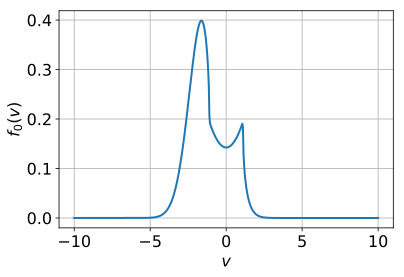

In [77]:
plt.plot(v,f0)
plt.xlabel(r'$v$')
plt.ylabel(r'$f_0(v)$')
# plt.yscale('log')
plt.grid()